<a href="https://www.bigdatauniversity.com"><img src = "https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width = 400, align = "center"></a>

<h1 align=center><font size = 5> Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [69]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [70]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2018-11-13 04:18:48--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2018-11-13 04:18:48 (11.8 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [71]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [72]:
df.shape

(346, 10)

### Convert to date time object 

In [73]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [74]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [75]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
seaborn                   0.9.0                    py35_0    anaconda


bins -  [  300.           377.77777778   455.55555556   533.33333333   611.11111111
   688.88888889   766.66666667   844.44444444   922.22222222  1000.        ]


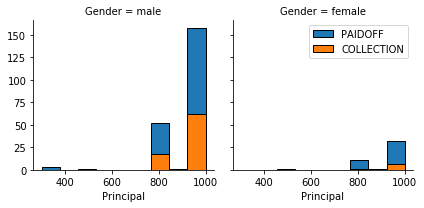

In [76]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
print('bins - ',bins)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

bins -  [ 18.          21.66666667  25.33333333  29.          32.66666667
  36.33333333  40.          43.66666667  47.33333333  51.        ]


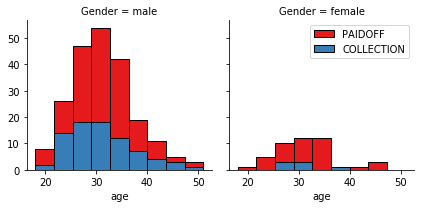

In [77]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
print('bins - ',bins)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

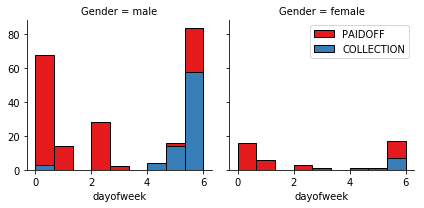

In [78]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [79]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [80]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [81]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [82]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [83]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [84]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [85]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [86]:
y = df['loan_status'].values

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [87]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

## Train Test Split

In [88]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=9)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# Model Evaluation Function

In [89]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

In [90]:
def evaluate_model(model, y_predicted, y_actual, predict_probability='NA'):
    jaccard_score_value = jaccard_similarity_score(y_actual, y_predicted)
    f1_score_value = f1_score(y_actual, y_predicted, average='weighted')
    log_score_value = 'NA'

    if (model == 'LogisticRegression'):
        log_score_value = log_loss(y_actual, predict_probability)

    return {
        'Algorithm': model,
        'Jaccard': jaccard_score_value,
        'F1-score': f1_score_value,
        'LogLoss': log_score_value
    }

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [91]:
from sklearn.neighbors import KNeighborsClassifier

In [92]:
#Train Model and Predict
knn_classsifier = KNeighborsClassifier().fit(X_train, y_train)
knn_classsifier

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [93]:
y_pred = knn_classsifier.predict(X_test)

In [94]:
knn_evaluation = evaluate_model('KNN', y_pred, y_test)
knn_evaluation

{'Algorithm': 'KNN',
 'F1-score': 0.73522267206477732,
 'Jaccard': 0.74285714285714288,
 'LogLoss': 'NA'}

with default value of K it gives this accuracy. Let's find out the best value of K.

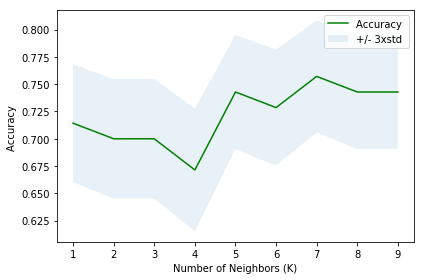

The best accuracy was with 0.757142857143 with k= 7


In [95]:
K = 10
mean_acc = np.zeros((K-1))
std_acc = np.zeros((K-1))
for k in range(1, K):
    knn_classsifier = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
    y_pred = knn_classsifier.predict(X_test)
    mean_acc[k-1] = accuracy_score(y_test, y_pred)
    std_acc[k-1] = np.std(y_pred==y_test)/np.sqrt(y_pred.shape[0])

# plot the line chart for all K values and their accuracy
plt.plot(range(1, K), mean_acc, 'g')
plt.fill_between(range(1, K), mean_acc - 1 * std_acc, mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

In [96]:
#Train KNN Model with K=7 and we will use same to form prediction on test data-set
knn_classsifier = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train)
y_pred = knn_classsifier.predict(X_test)
knn_evaluation = evaluate_model('KNN', y_pred, y_test)
knn_evaluation

{'Algorithm': 'KNN',
 'F1-score': 0.74573913043478268,
 'Jaccard': 0.75714285714285712,
 'LogLoss': 'NA'}

# Decision Tree

In [97]:
from sklearn.tree import DecisionTreeClassifier

In [98]:
decision_tree_classsifier = DecisionTreeClassifier(criterion="entropy", max_depth=5, min_samples_leaf=7, random_state=123).fit(X_train, y_train)

In [99]:
y_pred = decision_tree_classsifier.predict(X_test)

In [100]:
decision_tree_evaluation = evaluate_model('Decision Tree', y_pred, y_test)
decision_tree_evaluation

{'Algorithm': 'Decision Tree',
 'F1-score': 0.69333333333333336,
 'Jaccard': 0.68571428571428572,
 'LogLoss': 'NA'}

# Support Vector Machine

In [101]:
from sklearn import svm

In [102]:
svm_classifier = svm.SVC(kernel='linear').fit(X_train, y_train)

In [103]:
y_pred = svm_classifier.predict(X_test)

In [104]:
svm_evaluation = evaluate_model('SVM', y_pred, y_test)
svm_evaluation

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{'Algorithm': 'SVM',
 'F1-score': 0.71111111111111114,
 'Jaccard': 0.80000000000000004,
 'LogLoss': 'NA'}

# Logistic Regression

In [105]:
from sklearn.linear_model import LogisticRegression

In [106]:
logistic_regression_classifier = LogisticRegression(C=0.01, solver='liblinear').fit(X_train, y_train)

In [107]:
y_pred = logistic_regression_classifier.predict(X_test)
y_pred_prob = logistic_regression_classifier.predict_proba(X_test)

In [108]:
logistic_regression_evaluation = evaluate_model('LogisticRegression', y_pred, y_test, y_pred_prob)
logistic_regression_evaluation

{'Algorithm': 'LogisticRegression',
 'F1-score': 0.72596843615494977,
 'Jaccard': 0.7857142857142857,
 'LogLoss': 0.55100342425086435}

# Train Set Evaluation Report

In [109]:
pd.DataFrame([knn_evaluation, decision_tree_evaluation, svm_evaluation, logistic_regression_evaluation])

,Algorithm,F1-score,Jaccard,LogLoss
0,KNN,0.745739,0.757143,NA
1,Decision Tree,0.693333,0.685714,NA
2,SVM,0.711111,0.800000,NA
3,LogisticRegression,0.725968,0.785714,0.551003


# Model Evaluation using Test set

First, download and load the test set:

In [110]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2018-11-13 04:19:37--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2018-11-13 04:19:37 (688 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [111]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [112]:
# parsing dates
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

# addition of new column 'weekend'
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

# hot encoding 'Gender' feature values
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

# hot encoding remaining features
test_features = test_df[['Principal','terms','age','Gender','weekend']]
test_features = pd.concat([test_features,pd.get_dummies(test_df['education'])], axis=1)

# droping 'Master or Above' feature
test_features.drop(['Master or Above'], axis = 1,inplace=True)

# bringing all values in single scale
test_features = preprocessing.StandardScaler().fit(test_features).transform(test_features)
test_features[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

In [113]:
target_variable = test_df['loan_status'].values

In [114]:
KNN_test_evaluation = evaluate_model('KNN', knn_classsifier.predict(test_features), target_variable)
KNN_test_evaluation

{'Algorithm': 'KNN',
 'F1-score': 0.68606701940035264,
 'Jaccard': 0.70370370370370372,
 'LogLoss': 'NA'}

In [115]:
DT_test_evaluation = evaluate_model('Decision Tree', decision_tree_classsifier.predict(test_features), target_variable)
DT_test_evaluation

{'Algorithm': 'Decision Tree',
 'F1-score': 0.68129858253315045,
 'Jaccard': 0.68518518518518523,
 'LogLoss': 'NA'}

In [116]:
SVM_test_evaluation = evaluate_model('SVM', svm_classifier.predict(test_features), target_variable)
SVM_test_evaluation

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{'Algorithm': 'SVM',
 'F1-score': 0.63041765169424746,
 'Jaccard': 0.7407407407407407,
 'LogLoss': 'NA'}

In [117]:
LR_test_evaluation = evaluate_model('LogisticRegression', logistic_regression_classifier.predict(test_features), target_variable, logistic_regression_classifier.predict_proba(test_features))
LR_test_evaluation

{'Algorithm': 'LogisticRegression',
 'F1-score': 0.67176423735563517,
 'Jaccard': 0.7592592592592593,
 'LogLoss': 0.57423384799027}

# Test Set Evaluation Report

In [118]:
pd.DataFrame([KNN_test_evaluation, DT_test_evaluation, SVM_test_evaluation, LR_test_evaluation])

,Algorithm,F1-score,Jaccard,LogLoss
0,KNN,0.686067,0.703704,NA
1,Decision Tree,0.681299,0.685185,NA
2,SVM,0.630418,0.740741,NA
3,LogisticRegression,0.671764,0.759259,0.574234


## Want to learn more?

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: [SPSS Modeler](http://cocl.us/ML0101EN-SPSSModeler).

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at [Watson Studio](https://cocl.us/ML0101EN_DSX)


<hr>
Copyright &copy; 2018 [Cognitive Class](https://cocl.us/DX0108EN_CC). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).​

### Thanks for completing this lesson!

Notebook created by: <a href = "https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>